# Bayesian Neural Network with Variational Inference and Energy Loss

## Theoretic Foundation

BNN with VI and the energy loss is a simplicifcation extend BNNs with LVs. The BNN+LV model is proposed in [Depeweg, 2018](http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf) and this simplification follows by omitting the latent variables.

The likelihood is given by
$$
p(Y |\theta ,X) =
\prod_{i=1}^K p(y_i|\theta,z_i,x_i) =
\prod_{i=1}^K \mathcal{N}(y_{i} | f_{\theta}(x_i), \Sigma).
$$

The prior on the weights is obtained as for BNNs with VI and is given by,

$$
    p(\theta) = \prod_{l=1}^L \prod_{h=1}^{V_l }\prod_{j=1}^{V_{l-1}+1} \mathcal{N}(w_{hj, l} \vert 0, \lambda)
$$

where $w_{hj, l}$ is the h-th row and the j-th column of weight matrix $\theta_L$ at layer index $L$ and $\lambda$ is the prior variance. Note that as we use partially stochastic networks, the above may contain less factors $\mathcal{N}(w_{hj, l} \vert 0, \lambda)$ depending on how many layers are stochastic.

Then, with the assumed likelihood function and prior, a posterior over the
weights $\theta$ is obtained via Bayes' rule:
$$
p(\theta|\mathcal{D}) = \frac{p(Y|\theta,X)
p(\theta)}
{p(Y|X)}
$$

The approximate the posterior is given by

$$
q(\theta) =  \left[ \prod_{l=1}^L\! \prod_{h=1}^{V_l}\!  \prod_{j=1}^{V_{l\!-\!1}\!+\!1} \mathcal{N}(w_{hj,l}\vert m^w_{hj,l},v^w_{hj,l})\right].
$$

Now the parameters $m^w_{hj,l}$,$v^w_{hj,l}$ can be obtained
by minimizing a divergence between $p(\theta| \mathcal{D})$. Here the following approximation of the $\alpha$ divergence, as proposed in [Lobato, 2016](http://proceedings.mlr.press/v48/hernandez-lobatob16.pdf) and [Depeweg, 2016](https://arxiv.org/abs/1605.07127), is used,


$$
E_\alpha(q) = -\log Z_q - \frac{1}{\alpha} \sum_{n=1}^N
\log \mathbf{E}_{\Theta,\sim\, q}\left[ \left( \frac{p(\mathbf{y}_n | \Theta, \mathbf{x}_n, \mathbf{\Sigma)}}
{f(\Theta)}\right)^\alpha \right],
$$

where $Z_n$ is the normalising constant of the exponential form of the approximate the posterior and $f(\Theta)$ is a function depending on the parameters of the distributions  of prior on the weights, see [Depeweg, 2016](https://arxiv.org/abs/1605.07127) for details. In order to make this optimization problem scalable, SGD is used with mini-batches, and the expectation over $q$ is approximated with an average over $K$ samples drawn from $q$.

The posterior predictive distribution is given by,
$$
    p(y_{\star}\vert x_{\star}, \mathcal{D}) = \int   \mathcal{N}(y_{\star} \vert f_{\theta}(x_{\star}),  \Sigma) p(\theta \vert \mathcal{D}) d\theta.
$$

Again, the above posterior predictive distribution is intractable in this form. So instead we use sampling from the posterior distribution of the weights. The mean prediction is then given by the mean prediction of samples and the predictive uncertainty is obtained as standard deviation of samples from the approximation to the posterior predictive distribution.


## Imports

In [1]:
import tempfile
import os
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import BNN_VI_Regression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule(batch_size=50)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

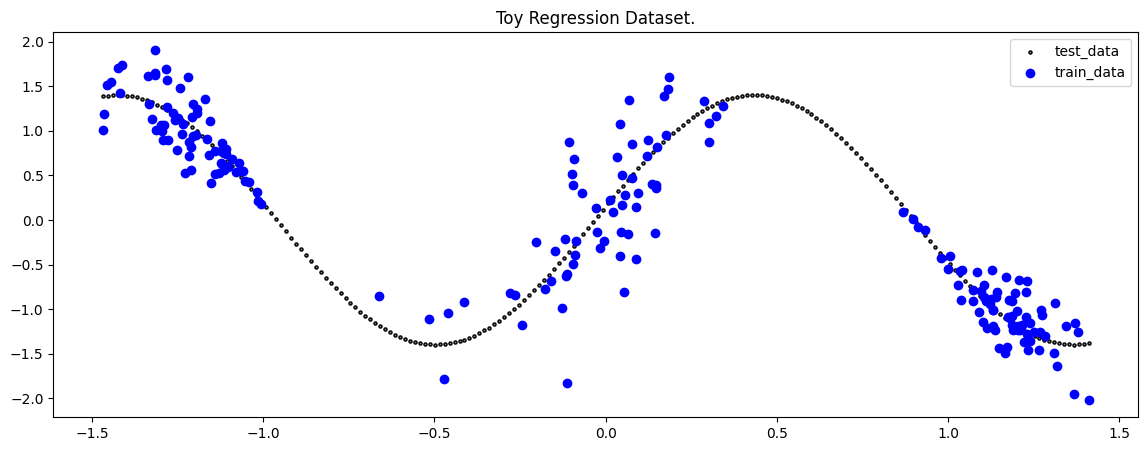

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [6]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [8]:
bnn_vi_model = BNN_VI_Regression(
    network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    num_training_points=X_train.shape[0],
    n_mc_samples_train=10,
    n_mc_samples_test=50,
    output_noise_scale=1.3,
    prior_mu=0.0,
    prior_sigma=1.0,
    posterior_mu_init=0.0,
    posterior_rho_init=-6.0,
    alpha=1e-03,
    bayesian_layer_type="reparameterization",
    stochastic_module_names=[-1],
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=200,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    limit_val_batches=0.0,  # no validation runs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(bnn_vi_model, dm)

Missing logger folder: /tmp/tmp9yauhd75/lightning_logs

  | Name               | Type                  | Params
-------------------------------------------------------------
0 | model              | MLP                   | 2.8 K 
1 | train_metrics      | MetricCollection      | 0     
2 | val_metrics        | MetricCollection      | 0     
3 | test_metrics       | MetricCollection      | 0     
4 | energy_loss_module | EnergyAlphaDivergence | 0     
5 | nll_loss           | GaussianNLLLoss       | 0     
  | other params       | n/a                   | 1     
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

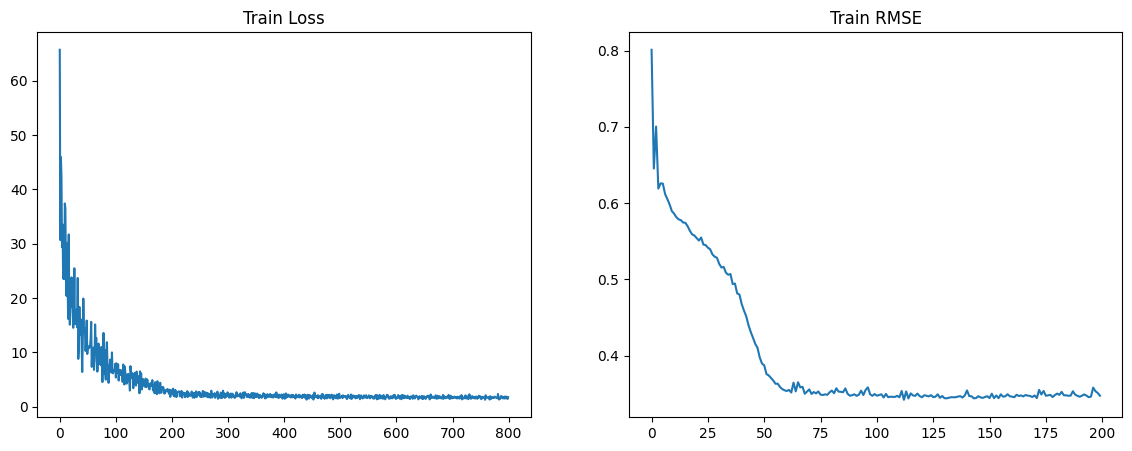

In [11]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

In [12]:
preds = bnn_vi_model.predict_step(X_test)

## Evaluate Predictions

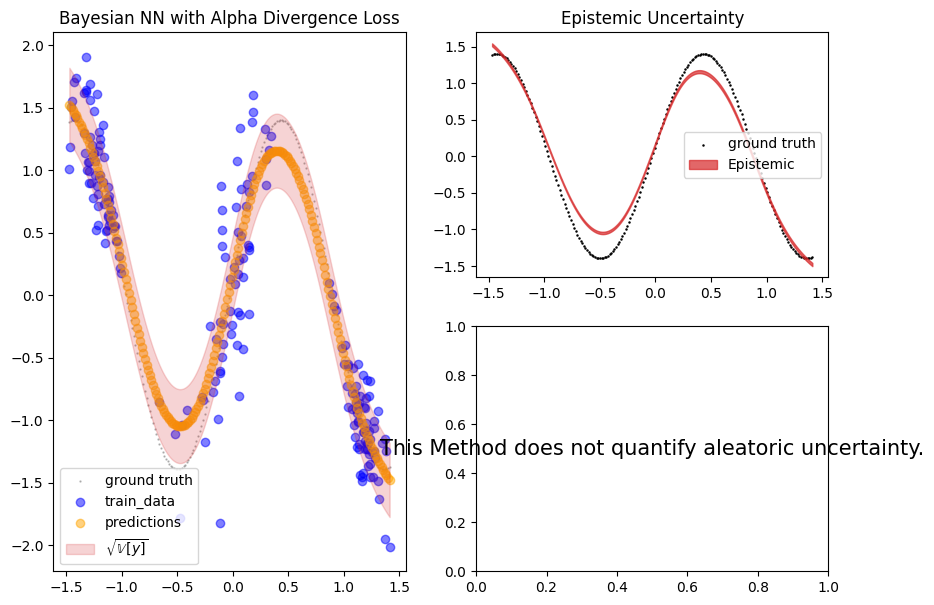

In [13]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    # aleatoric=preds["aleatoric_uct"],
    title="Bayesian NN with Alpha Divergence Loss",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

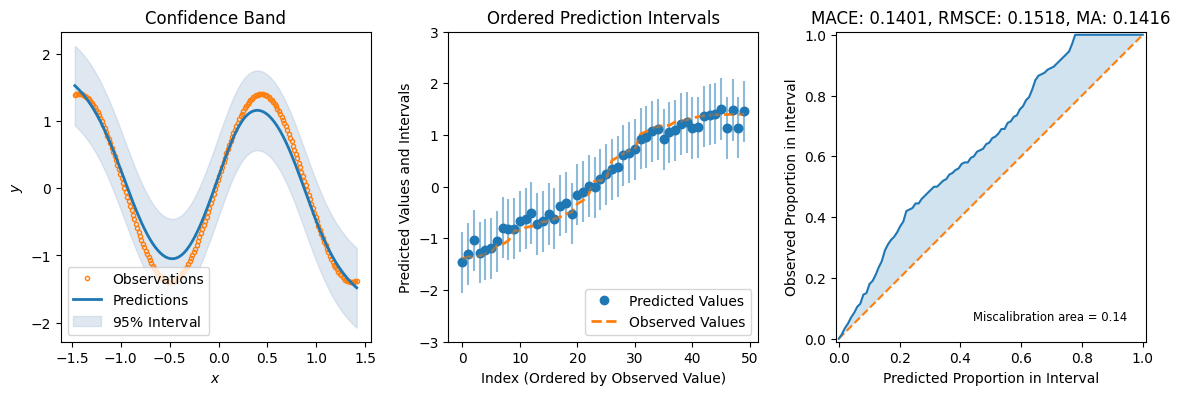

In [14]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)